# Boston Marathon - Modeling

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import normalize
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists
import warnings
warnings.filterwarnings('ignore')

import helpers as hp
from config import usr, pwd, url, port, db, table

## Load Dataset
Read dataset from the SQL database and load into a Pandas `DataFrame`.

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {table};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
engine.dispose()

Copy raw `DataFrame` to a new `DataFrame` to use for modeling purposes.

In [6]:
df_model = df.copy()

## Data Exploration
### Split variable types
Create separate lists of column names for the numerical and string type column data.

Let's investigate the distributions of the numerical values in this dataset.

In [7]:
numerical_vars, string_vars = hp.find_variable_types(df_model)

In [8]:
print(string_vars)

['name', 'gender', 'bib', 'ctz', 'state', 'country', 'city']


### Correlations
I will investigate which numerical variables are correlated with eachother and only keep the variables that are uncorrelated.

In [9]:
df_model.loc[:, numerical_vars].corr()

,10.0,division,25.0,age,official,genderdiv,35.0,overall,pace,30.0,5.0,21.1,20.0,40.0
10.0,1.000000,0.471278,0.971632,0.167492,0.926539,0.797326,0.942697,0.900856,0.926638,0.958461,0.988725,0.982808,0.982447,0.928195
division,0.471278,1.000000,0.490299,-0.577256,0.515368,0.470752,0.510940,0.514493,0.515633,0.500938,0.470117,0.481394,0.481330,0.518512
25.0,0.971632,0.490299,1.000000,0.158120,0.968160,0.819000,0.983987,0.918578,0.968159,0.995227,0.947264,0.995672,0.993279,0.970671
age,0.167492,-0.577256,0.158120,1.000000,0.166440,0.306829,0.157314,0.201129,0.166593,0.156746,0.159665,0.164862,0.164730,0.160384
official,0.926539,0.515368,0.968160,0.166440,1.000000,0.878360,0.991774,0.954233,0.999897,0.980873,0.904008,0.957356,0.954294,0.996592
genderdiv,0.797326,0.470752,0.819000,0.306829,0.878360,1.000000,0.855535,0.909206,0.878789,0.836303,0.786523,0.812231,0.811227,0.873438
35.0,0.942697,0.510940,0.983987,0.157314,0.991774,0.855535,1.000000,0.942725,0.992047,0.993996,0.918225,0.973611,0.971620,0.994949
overall,0.900856,0.514493,0.918578,0.201129,0.954233,0.909206,0.942725,1.000000,0.954765,0.930739,0.888560,0.914568,0.913992,0.952727
pace,0.926638,0.515633,0.968159,0.166593,0.999897,0.878789,0.992047,0.954765,1.000000,0.981002,0.904186,0.957318,0.954388,0.997207
30.0,0.958461,0.500938,0.995227,0.156746,0.980873,0.836303,0.993996,0.930739,0.981002,1.000000,0.933435,0.987289,0.985146,0.983998


There are a log of correlated variables. This is especially true between the variables related to times, like split times, pace, overall time, etc. Let's find the highly correlated columns and remove them.

In [10]:
correlated_vars = hp.find_correlated_features(df_model.loc[:, numerical_vars])

Correlated Columns (r > 0.8):
* 25.0
* official
* genderdiv
* 35.0
* overall
* pace
* 30.0
* 5.0
* 21.1
* 20.0
* 40.0
11 correlated features will be removed.


In [11]:
df_model.drop(columns=correlated_vars).corr()

,10.0,division,age
10.0,1.000000,0.471278,0.167492
division,0.471278,1.000000,-0.577256
age,0.167492,-0.577256,1.000000


In [12]:
uncorrelated_vars = df_model.drop(columns=correlated_vars).corr().columns.tolist()

## Numerical variable distributions
I will investigate the distributions of the uncorrelated variables.

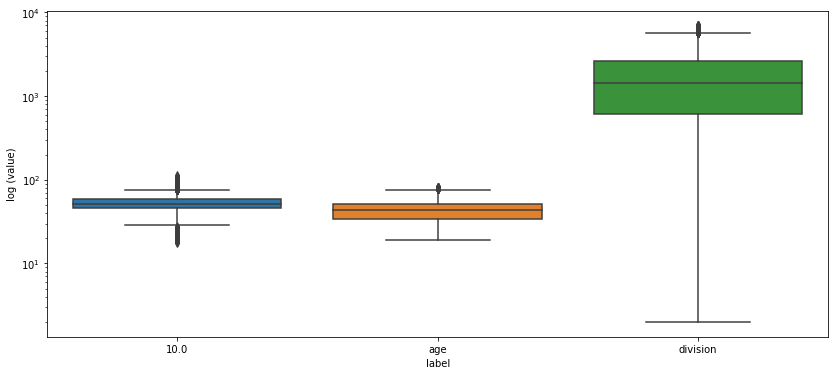

In [13]:
hp.create_boxplots(df_model, uncorrelated_vars, log_scale=True)

## Outliers
Correct for outliers.

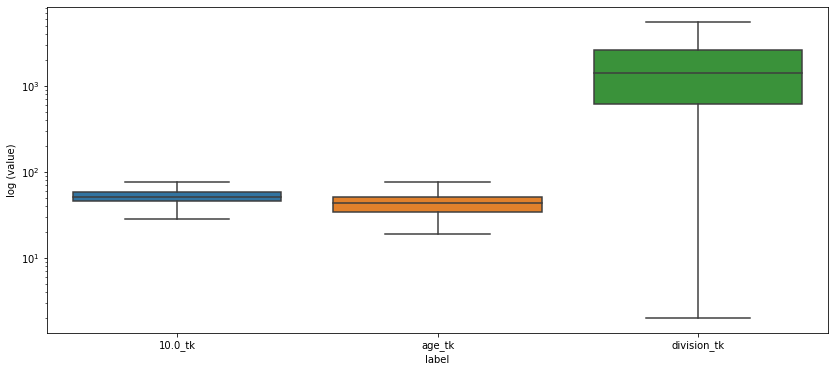

In [14]:
outlier_corrected = [f'{x}_tk' for x in uncorrelated_vars]
hp.correct_outliers(df_model, uncorrelated_vars)
hp.create_boxplots(df_model, outlier_corrected, log_scale=True)

### Normalized

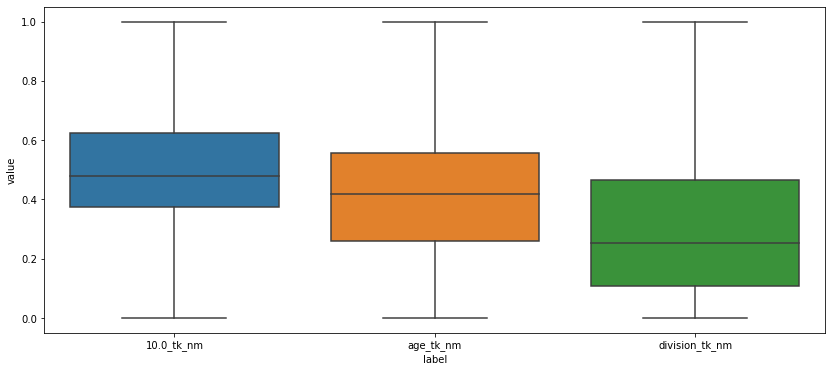

In [15]:
normalized = [f'{x}_nm' for x in outlier_corrected]
hp.apply_transform(df_model, outlier_corrected, 'normalize')
hp.create_boxplots(df_model, normalized)

In [16]:
df_model.loc[:, uncorrelated_vars+string_vars].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
10.0,31984,NaN,NaN,NaN,51.8198,8.99965,16.62,45.4,50.35,57.18,112.38
division,31984,NaN,NaN,NaN,1932.56,1715.23,1,610,1425,2611,6979
age,31984,NaN,NaN,NaN,42.4071,11.3165,18,33,42,50,81
name,31984,31915,"Williamson, Kelly",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,31984,2,M,17617,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bib,31984,31984,22378,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctz,31984,85,unknown,30740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,31984,69,MA,7587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,31984,78,USA,27233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,31983,5934,Boston,1034,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modeling
### Features
Use split times and pace as the features. Normalize them for better modeling fitting.

In [17]:
X_norm = df_model.loc[:, normalized].values

In [18]:
X_norm.shape

(31984, 3)

### Label
Use gender as the label. Convert gender into 1s and 0s.

In [19]:
y = np.where(df_model['gender'].values == 'M', 0, 1)

In [20]:
print(len(y[y > 0]))
print(len(y[y == 0]))

14367
17617


### K-means

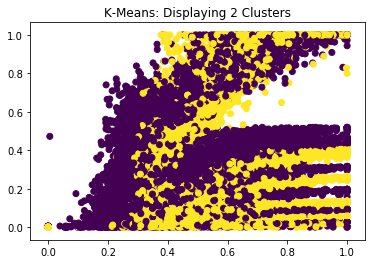

Contingency Table
actual         0     1
predicted             
0          14305  3312
1           9961  4406
ARI: 0.026


In [21]:
hp.fit_kmeans(X_norm, y, 2, evaluate_model=True)

### Mean Shift

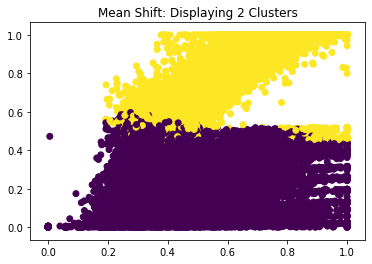

There are 2 estimated clusters.
Contingency Table
actual         0     1
predicted             
0          14606  3011
1          10188  4179
ARI: 0.027


In [22]:
hp.fit_mean_shift(X_norm, y, evaluate_model=True)

### Spectral Clustering

In [23]:
hp.fit_spectral_clustering(X_norm, y, 2, evaluate_model=True)

KeyboardInterrupt: 